In [1]:
# 4.4.4. Polynomial Regression 
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

In [2]:
# 4.4.4.1. Generating the Dataset
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
# random.normal(loc=0.0, scale=1.0, size=None)
# loc: 此概率分佈的均值（對應著整個分佈的中心centre）
# scale: 此概率分佈的標準差（對應於分佈的寬度，scale越大越矮胖，scale越小，越瘦高）
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
# numpy.power(arr1，arr2，out = None，where = True，cast ='same_kind'，order ='K'，dtype = None)
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
    # [:, i] -> n examples, ith element of each row
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.2912],
         [ 1.4811]]),
 tensor([[ 1.0000e+00, -2.9119e-01,  4.2397e-02, -4.1152e-03,  2.9958e-04,
          -1.7447e-05,  8.4675e-07, -3.5224e-08,  1.2821e-09, -4.1483e-11,
           1.2080e-12, -3.1977e-14,  7.7597e-16, -1.7381e-17,  3.6152e-19,
          -7.0182e-21,  1.2773e-22, -2.1879e-24,  3.5394e-26, -5.4245e-28],
         [ 1.0000e+00,  1.4811e+00,  1.0969e+00,  5.4153e-01,  2.0052e-01,
           5.9399e-02,  1.4663e-02,  3.1025e-03,  5.7440e-04,  9.4528e-05,
           1.4001e-05,  1.8852e-06,  2.3268e-07,  2.6510e-08,  2.8046e-09,
           2.7693e-10,  2.5636e-11,  2.2335e-12,  1.8378e-13,  1.4327e-14]]),
 tensor([4.5970, 6.1207]))

In [4]:
# 4.4.4.2. Training and Testing the Model
def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0108666  1.2005686 -3.416932   5.5862336]]


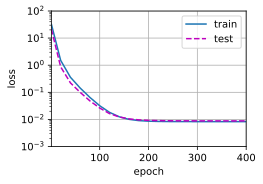

In [6]:
# 4.4.4.3. Third-Order Polynomial Function Fitting (Normal)
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.1720977 3.9326797]]


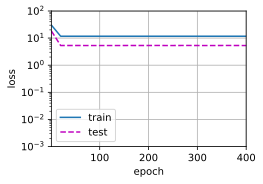

In [7]:
# 4.4.4.4. Linear Function Fitting (Underfitting)
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 5.004377    1.2851447  -3.3816211   5.150272   -0.05279603  1.173869
  -0.01451939 -0.06531902  0.0808457   0.06708545 -0.09870883  0.17788014
   0.11163799 -0.08979206 -0.19260824 -0.03097861 -0.19364552 -0.09883858
   0.14103636 -0.20770231]]


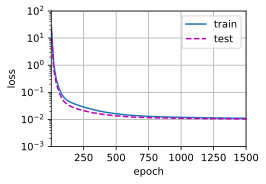

In [8]:
# 4.4.4.5. Higher-Order Polynomial Function Fitting (Overfitting)
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)